# RF superconducting resonators 101

This example shows a basic demonstration of reading out the transmission data from emulated superconducting resonators and fitting that data.

Then we move on to showing how the resonator can jump from one frequency to the other, emulating a qubit undergoing energy relaxation (T1 decay).

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from hist_analysis import *
from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm
from random import *
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import cauchy

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('../firmware/qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.268
	Firmware timestamp: Wed Sep  6 15:36:36 2023

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-b

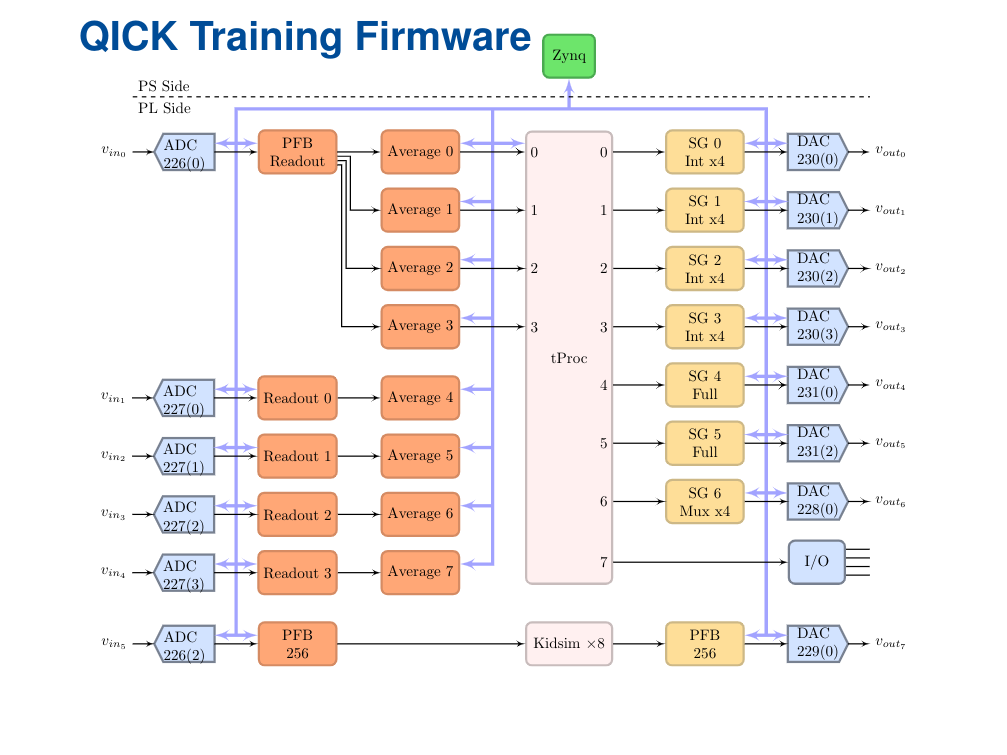

In [3]:
from IPython.display import Image, display
display(Image(filename='images/Qick_training.png', embed=True))

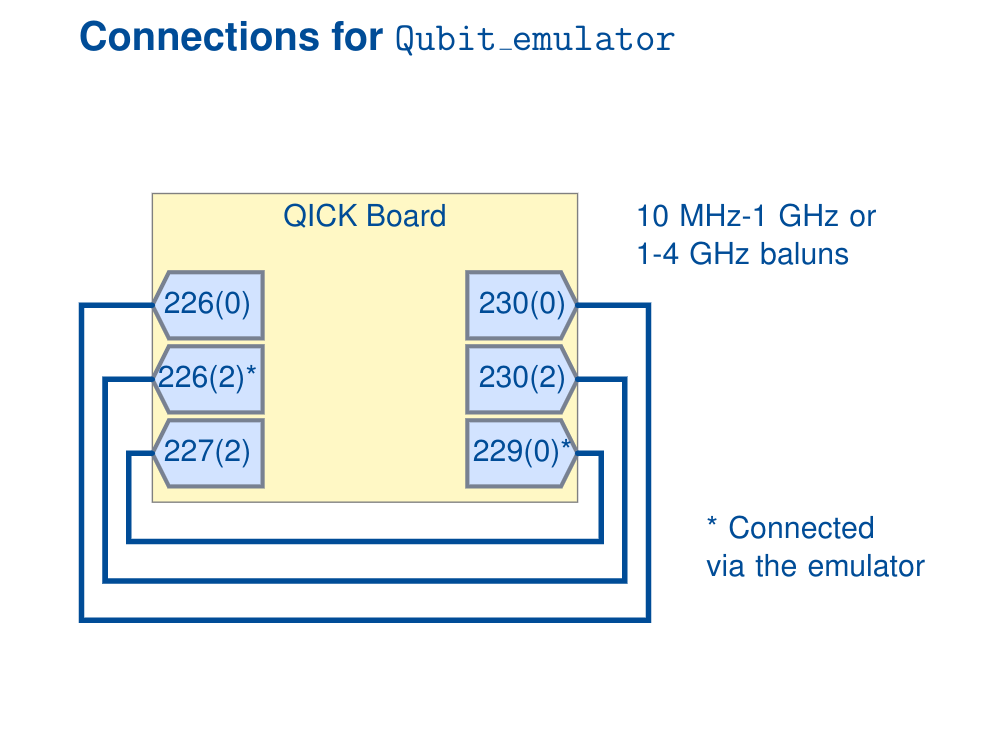

In [4]:
display(Image(filename='images/Connections_Qubit_emulator.png', embed=True))

In [5]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

# RF superconducting resonator 101

# Why are superconducting resonators important?

* 1. You can use them to read out superconducting qubits in a way that does not destroy the quantum state of the qubit (quantum nondemolition readout), like we talked about in this morning's lecture. 
    * Our reference from lecture: https://arxiv.org/abs/2106.06173 
    
* 2. You can also do things the other way around, and use a superconducting qubit to read out the resonator, and store the quantum information in the resonator instead. 
    * This is used to search for axion dark matter, which is a useful practical application of today's noisy superconducting qubits: https://arxiv.org/abs/2008.12231
    
* 3. You can fabricate high-quality-factor resonators to learn about how to fabricate low-loss superconducting films and therefore you can learn how to make better films for your qubits (which are more complicated to fabricate).
    * There are many papers about this, for example https://arxiv.org/pdf/2211.16437 

# Set up your resonator

This resonator's frequency is 500 MHz. The resonator has a certain quality factor, which you will extract by fitting it in a cell below.

In [54]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


fr = 500
res_jump_time = 6.2
### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : fr}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = res_jump_time # should be a little longer than readout time (5 us)
cfg['iir_c0'] = 0.85 #0.99
cfg['iir_c1'] = 0.8 #0.8
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 500 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.85
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9729729729729729
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 58
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 6.2
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 6144, slope = 6144, steps = 1, wait = 58
c0 = 27853, c1 = 26214, g = 31882
sel = 0, punct_id = 29, addr = 0


In [55]:
class ResonatorJump(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=2, mixer_freq=0)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             gen_ch  = self.cfg['gen_ch'])        
        
        self.synci(200)  # give processor some time to configure pulses      
    
    def body(self):
        # Trigger.
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=0)

        # Pulse.
        self.pulse(ch = self.cfg['gen_ch'], t=0)
        
        # Resonator Jump.
        if self.cfg['do_jump']:
            self.trigger(pins=list(range(4,12)),t=self.us2cycles(self.cfg['trigger_off']))
        

# Resonator spectroscopy

By measuring the complex S_21 of the resonator around its resonant frequency, we can find its resonance and then fit it to find its quality factor. Let's measure this S_21 of our resonator.

In [56]:
# Frequency sweep.
fc = fr
df = 20
fstart = fc - df/2
fstop = fc + df/2
N = 1500
config={"gen_ch"      : 2,
        "reps"        : 1,
        "soft_avgs"   : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 500, # [MHz]
        "trigger_off" : 5,
        "ro_ch"     : 6,
        "ro_length" : 30,
        'do_jump' : False
       }
freqs = np.linspace(start=fstart, stop=fstop, num=N)
print('Sweep Parameters')
print('* fstart = {} MHz'.format(fstart))
print('* fstop  = {} MHz'.format(fstop))
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(freqs[1]-freqs[0]))
iqs = []
for f in tqdm(freqs):
    config['pulse_freq'] = f
    prog = ResonatorJump(soccfg, config)
    iq = prog.acquire(soc, progress=False)
    iqs.append(iq[0][0][0]+1j*iq[1][0][0])
iqs = np.array(iqs)

# plt.semilogy(freqs, np.abs(iqs))

Sweep Parameters
* fstart = 490.0 MHz
* fstop  = 510.0 MHz
* N      = 1500
* fr     = 0.013342228152112057 MHz


  0%|          | 0/1500 [00:00<?, ?it/s]

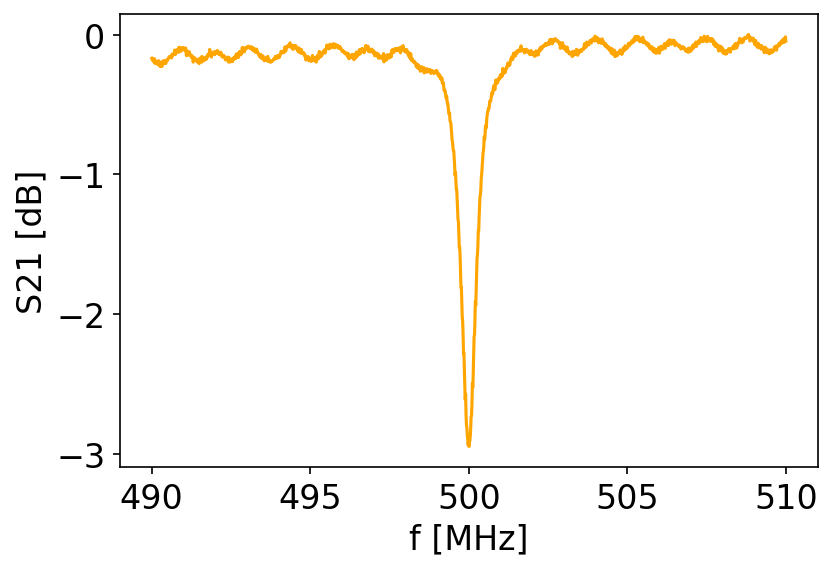

In [57]:
mags = np.abs(iqs)
phi = np.angle(iqs)
S21 = 20*np.log10(mags/np.max(mags))

#############
### Plots ###
#############
plt.figure(dpi=150)
plt.plot(freqs,S21,color='orange')
plt.xlabel('f [MHz]')
plt.ylabel('S21 [dB]');

In [58]:
# ## Save data (optional)
# import pickle
# saveDict = {'freqs': freqs, 'S21': S21, 'xi_v': xi_v, 'xq_v': xq_v}

# with open('resData_iq.pkl', 'wb') as handle:
#     pickle.dump(saveDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Let's fit this resonator and extract its quality factor. 

Q = f/kappa, where kappa is the linewidth of the resonator-- its full width at half maximum.

### 1. Find the full width, half maximum (kappa) of the resonator, analytically.

In [59]:
def lorentzian(f, gamma, f0, A):
    return (A/np.pi) / (gamma) / (1 + np.power((f-f0)/(gamma),2.))

def FWHM_analytic(f, S21):
    f_min = f[np.argmin(S21)] #; print(f_min)
    S_min = np.min(S21) #; print(S_min)
    halfmax = S_min/2 #; print(halfmax)
    hm_f_lo = f[f<f_min][np.argmin(np.abs(S21[f<f_min]-halfmax))] #; print(hm_f_lo)
    hm_f_hi = f[f>f_min][np.argmin(np.abs(S21[f>f_min]-halfmax))] #; print(hm_f_hi)
    FWHM = hm_f_hi - hm_f_lo
    return f_min, S_min, FWHM

In [60]:
### Solution:

f_min , S_min, FWHM = FWHM_analytic(freqs, S21)
print(f_min)
print(S_min)
print("FWHM from straight calculation:", FWHM)

500.006671114076
-2.946088766661293
FWHM from straight calculation: 0.600400266844531


### 2. Fit the resonator to a Lorentzian using the scipy `curve_fit` function. Do so by zooming in to the center of your data to get a good fit (right around the resonance)

You will need to make a guess at the FWHM, the resonance frequency, and an overall factor corresponding to the amplitude of your resonator dip (see the Lorentzian function above).

FWHM from fit: 0.3100312202946321
Amplitude factor from fit: -2.817099227002712


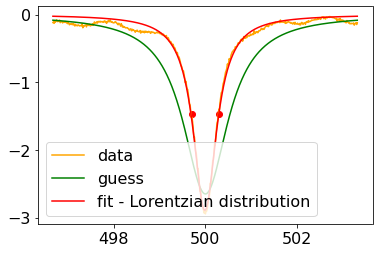

In [62]:
### Solution:

min_idx = int(500)
max_idx = int(1000)

plt.scatter([f_min-FWHM/2.],[S_min/2.],color='r',marker='o')
plt.scatter([f_min+FWHM/2.],[S_min/2.],color='r',marker='o')

guess = [FWHM , f_min , -5]
gss_lorentzian = lorentzian(freqs, *guess)
popt, pcov = curve_fit(lorentzian, freqs[min_idx:max_idx], S21[min_idx:max_idx], maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21[min_idx:max_idx], color='orange', label="data")
plt.plot(freqs[min_idx:max_idx], gss_lorentzian[min_idx:max_idx], color='green', label="guess")
plt.plot(freqs[min_idx:max_idx], fit_lorentzian[min_idx:max_idx], color='red', label="fit - Lorentzian distribution")
plt.legend()

print("FWHM from fit:", popt[0])
print("Amplitude factor from fit:", popt[2])

### 3. Use the linewidth you fitted to compute the quality factor of your resonator.

In [63]:
### Solution:

kappa = popt[0] ## Resonator linewidth (gamma of the Lorentzian function)
f = popt[1] ## Resonator center frequency
gain_factor = popt[2] ## Gain factor associated with Lorentzian function
Q = f/kappa
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~1612


### 4. Compare this quality factor to the quality factor of the readout resonator in the QICK paper: https://arxiv.org/abs/2110.00557 Figure 14

In [64]:
### Solution:

kappa = 1e6 ## Resonator linewidth from QICK paper
f = 8.5015e9 ## Resonator center frequency from QICK paper
Q = f/kappa
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~8501


### 5. Our Lorentzian fit is OK but its not perfect. Let's try to fit a pole-zero function to the magnitude of the signal.

pole-zero fit: [499.99409179   0.78705811   0.7159561   17.88860569]


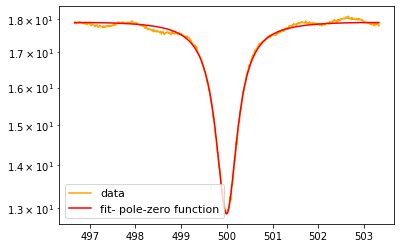

In [18]:
def polezero(f, f0, c0, c1, G):
    z = np.exp(1j*f)
    # apply an overall G0 = (1+c1)/(1+c0) which seems to normalize to 1 far from the resonance
    G0 = (1+c1)/(1+c0)
    return G*G0*np.abs((z-c0*np.exp(1j*f0))/(z-c1*np.exp(1j*f0)))


plt.semilogy(freqs[500:1000], mags[500:1000], label='data', color='orange')

guess = [f_min, 0.85, 0.8, np.max(mags)]
popt, pcov = curve_fit(polezero, freqs[500:1000], mags[500:1000], maxfev = 100000, p0 = guess)
fit_polezero = polezero(freqs[500:1000], *popt)
plt.semilogy(freqs[500:1000], fit_polezero, label='fit- pole-zero function', color='red')
plt.legend(loc='lower left',prop={'size': 11})

print("pole-zero fit:", popt)

### Varying coefficient c0 sets the depth of the minimum

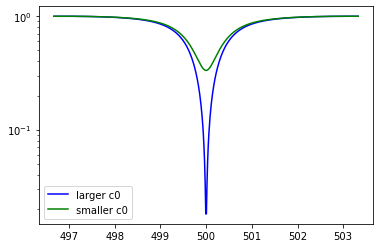

In [19]:
plt.semilogy(freqs[500:1000], polezero(freqs[500:1000], 500, 0.99, 0.5, 1.0), label='larger c0',color='blue')
plt.semilogy(freqs[500:1000], polezero(freqs[500:1000], 500, 0.8, 0.5, 1.0),label='smaller c0',color='green')
plt.legend()

### Varying coefficient c1 sets the width scale

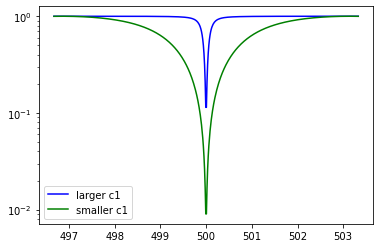

In [20]:
plt.semilogy(freqs[500:1000], polezero(freqs[500:1000], 500, 0.99, 0.9, 1.0), label='larger c1',color='blue')
plt.semilogy(freqs[500:1000], polezero(freqs[500:1000], 500, 0.99, 0.2, 1.0), label='smaller c1',color='green')
plt.legend()

### To lower the resonator's quality factor, lower c0=0.8 or 0.7, and then choose c1 < c0 e.g. c1=0.5 or 0.4. 

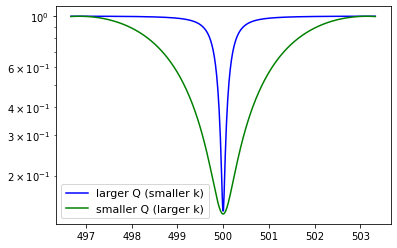

In [21]:
plt.semilogy(freqs[500:1000], polezero(freqs[500:1000], 500, 0.97, 0.8, 1.0), label='larger Q (smaller k)',color='blue')
plt.semilogy(freqs[500:1000], polezero(freqs[500:1000], 500, 0.8, 0.1, 1.0),label='smaller Q (larger k)',color='green')
plt.legend(loc='lower left', prop={'size': 11})

# Fitting a different resonator

There are 2 parameters that determine the quality factor of our resonator: iir_c0 and iir_c1. These are the parameters c0 and c1 that we just discussed. These are the zero (c0) and pole (c1) location for the 1st order IIR FPGA filter that has been designed for the QICK to emulate a resonator.

* Here's a reference about this, but this is outside the scope of our lab: https://brianmcfee.net/dstbook-site/content/ch12-ztransform/PoleZero.html 

In [22]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


fr = 500
res_jump_time = 6.2
### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : fr}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = res_jump_time # should be a little longer than readout time (5 us)
cfg['iir_c0'] = 0.8 #0.99
cfg['iir_c1'] = 0.4 #0.8
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 500 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.8
AxisKidsimV3: iir_c1     = 0.4
AxisKidsimV3: iir_g      = 0.7777777777777777
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 58
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 6.2
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 6144, slope = 6144, steps = 1, wait = 58
c0 = 26214, c1 = 13107, g = 25486
sel = 0, punct_id = 29, addr = 0


# Resonator spectroscopy

By measuring the complex S_21 of the resonator around its resonant frequency, we can find its resonance and then fit it to find its quality factor. Let's measure this S_21 of our resonator.

In [23]:
# Frequency sweep.
fc = fr
df = 20
fstart = fc - df/2
fstop = fc + df/2
N = 1500
config={"gen_ch"      : 2,
        "reps"        : 1,
        "soft_avgs"   : 1,
        "pulse_length": 25,
        "pulse_gain"  : 8000, # [DAC units]
        "pulse_freq"  : 500, # [MHz]
        "trigger_off" : 5,
        "ro_ch"     : 6,
        "ro_length" : 30,
        'do_jump' : False
       }
freqs = np.linspace(start=fstart, stop=fstop, num=N)
print('Sweep Parameters')
print('* fstart = {} MHz'.format(fstart))
print('* fstop  = {} MHz'.format(fstop))
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(freqs[1]-freqs[0]))
iqs = []
for f in tqdm(freqs):
    config['pulse_freq'] = f
    prog = ResonatorJump(soccfg, config)
    iq = prog.acquire(soc, progress=False)
    iqs.append(iq[0][0][0]+1j*iq[1][0][0])
iqs = np.array(iqs)

# plt.semilogy(freqs, np.abs(iqs))

Sweep Parameters
* fstart = 490.0 MHz
* fstop  = 510.0 MHz
* N      = 1500
* fr     = 0.013342228152112057 MHz


  0%|          | 0/1500 [00:00<?, ?it/s]

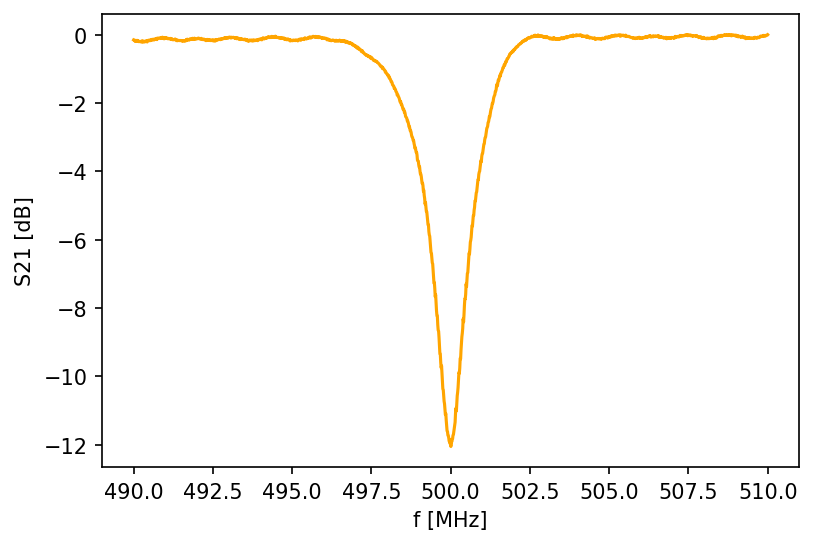

In [24]:
mags = np.abs(iqs)
phi = np.angle(iqs)
S21 = 20*np.log10(mags/np.max(mags))

#############
### Plots ###
#############
plt.figure(dpi=150)
plt.plot(freqs,S21,color='orange')
plt.xlabel('f [MHz]')
plt.ylabel('S21 [dB]');

### Let's fit this resonator and extract its quality factor. 

Q = f/kappa, where kappa is the linewidth of the resonator-- its full width at half maximum.

### 1. Find the full width, half maximum (kappa) of the resonator, analytically.

In [43]:
def lorentzian(f, gamma, f0, A):
    return (A/np.pi) / (gamma) / (1 + np.power((f-f0)/(gamma),2.))

def FWHM_analytic(f, S21):
    f_min = f[np.argmin(S21)] #; print(f_min)
    S_min = np.min(S21) #; print(S_min)
    halfmax = S_min/2 #; print(halfmax)
    hm_f_lo = f[f<f_min][np.argmin(np.abs(S21[f<f_min]-halfmax))] #; print(hm_f_lo)
    hm_f_hi = f[f>f_min][np.argmin(np.abs(S21[f>f_min]-halfmax))] #; print(hm_f_hi)
    FWHM = hm_f_hi - hm_f_lo
    return f_min, S_min, FWHM

In [44]:
### Solution:

f_min , S_min, FWHM = FWHM_analytic(freqs, S21)
print(f_min)
print(S_min)
print("FWHM from straight calculation:", FWHM)

500.006671114076
-12.053101279350695
FWHM from straight calculation: 1.2808539026017343


### 2. Fit the resonator to a Lorentzian using the scipy `curve_fit` function. Do so by zooming in to the center of your data to get a good fit (right around the resonance)

You will need to make a guess at the FWHM, the resonance frequency, and an overall factor corresponding to the amplitude of your resonator dip (see the Lorentzian function above).

FWHM from fit: 0.6331902618521903
Amplitude factor from fit: -23.676820501770433


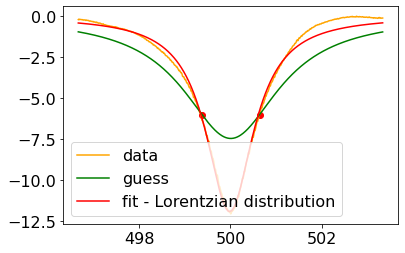

In [45]:
### Solution:

min_idx = int(500)
max_idx = int(1000)

plt.scatter([f_min-FWHM/2.],[S_min/2.],color='r',marker='o')
plt.scatter([f_min+FWHM/2.],[S_min/2.],color='r',marker='o')

guess = [FWHM , f_min , -30]
gss_lorentzian = lorentzian(freqs, *guess)
popt, pcov = curve_fit(lorentzian, freqs[min_idx:max_idx], S21[min_idx:max_idx], maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21[min_idx:max_idx], color='orange', label="data")
plt.plot(freqs[min_idx:max_idx], gss_lorentzian[min_idx:max_idx], color='green', label="guess")
plt.plot(freqs[min_idx:max_idx], fit_lorentzian[min_idx:max_idx], color='red', label="fit - Lorentzian distribution")
plt.legend()

print("FWHM from fit:", popt[0])
print("Amplitude factor from fit:", popt[2])

### 3. Use the linewidth you fitted to compute the quality factor of your resonator.

In [46]:
### Solution:

kappa = popt[0] ## Resonator linewidth (gamma of the Lorentzian function)
f = popt[1] ## Resonator center frequency
gain_factor = popt[2] ## Gain factor associated with Lorentzian function
Q = f/kappa
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~789


### 4. Our Lorentzian fit is OK but its not perfect. Let's try to fit a pole-zero function to the magnitude of the signal.

pole-zero fit: [4.99952690e+02 7.08260530e-01 2.06478468e-01 1.77079853e+01]


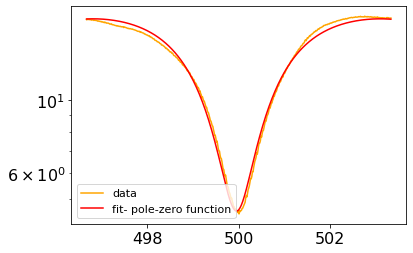

In [47]:
def polezero(f, f0, c0, c1, G):
    z = np.exp(1j*f)
    # apply an overall G0 = (1+c1)/(1+c0) which seems to normalize to 1 far from the resonance
    G0 = (1+c1)/(1+c0)
    return G*G0*np.abs((z-c0*np.exp(1j*f0))/(z-c1*np.exp(1j*f0)))


plt.semilogy(freqs[500:1000], mags[500:1000], label='data', color='orange')

guess = [f_min, 0.8, 0.4, np.max(mags)]
popt, pcov = curve_fit(polezero, freqs[500:1000], mags[500:1000], maxfev = 100000, p0 = guess)
fit_polezero = polezero(freqs[500:1000], *popt)
plt.semilogy(freqs[500:1000], fit_polezero, label='fit- pole-zero function', color='red')
plt.legend(loc='lower left',prop={'size': 11})

print("pole-zero fit:", popt)

### 5. Compare the fitted c0 and c1 than what the resonator was set to. Do they match?

In [48]:
## Solution:
## c0 was set to 0.8 and c1 was set to 0.4, but the fit shows c0 as 0.72 and c1 as 0.2, so they don't match...

### 6. Compare the fitted c0 and c1 to the first resonator. Which would you expect to have a higher Q?

In [49]:
## Solution:
## c0 for resonator 2 is lower than resonator 1 and c1 is much lower than resonator 1.
## So you'd expect resonator 2 to have a lower Q than resonator 1, which agrees with our Lorentzian fit.

# Overlaying a fit to the resonator to visualize its transfer function S21

Plot functions credit to Professor Alex Ma: https://colab.research.google.com/drive/1sLLlLYMNsGkx8GDkBFPCNZmclJiPkWvr?usp=sharing#scrollTo=TNvM-OswNped 

Ma lab website: https://www.ma-quantumlab.com/ 

In [50]:
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.pyplot import *
from scipy import *
from numpy import *
import time

from matplotlib.pyplot import *
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

from ipywidgets import interactive, fixed
import ipywidgets as widgets
from IPython.display import display

In [51]:
def plot_resonance(dw, Sdata, fmin, amp, freq_data, S21_data, label):
    dw_range = max(dw)
    figure(figsize=[15,9])
    ax = subplot(2,3,1); title("Abs "+label); plot(dw+fmin, abs(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-0.5, 1.5)
    axhline(1.0, ls='--')
    ax.plot(freq_data, -1/amp*S21_data+1, label="data")
    ax.legend(loc='lower left', prop={'size': 10})
    
    ax = subplot(2,3,2); title("Arg "+label); plot(dw+fmin, angle(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-pi,pi)
    axhline(0.0, ls='--')

    ax = subplot(2,3,3); title("Complex "+label); plot(real(Sdata), imag(Sdata))
    ax.set_xlim(-1.05, 1.05); ax.set_ylim(-1.05, 1.5)
    axhline(0.0, ls='--'); axvline(0.0, ls='--')

    ax = subplot(2,3,4); title("Re "+label); plot(dw+fmin, real(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-1.5, 1.5)
    axhline(0.0, ls='--')

    ax = subplot(2,3,5); title("Im "+label); plot(dw+fmin, imag(Sdata))
    ax.set_xlim(fmin-dw_range,fmin+dw_range); ax.set_ylim(-1.5, 1.5)
    axhline(0.0, ls='--')

    show()

Source for the hanger equation: e.g. Equation 1 of https://arxiv.org/abs/0908.2948

In [52]:
def plotHanger(fmin, amp, freq_data, S21_data, dw_range, k_inner, k_out):
      dw = np.linspace(-dw_range,dw_range,1001)
      S21 = 1j*(1-k_out/(k_inner+2.0j*dw+k_out))
      plot_resonance(dw, S21, fmin, amp, freq_data, S21_data, label='S21')

In [53]:
interactive_plot = interactive(plotHanger, 
                               fmin=fixed(f_min), amp=fixed(gain_factor), 
                               freq_data=fixed(freqs),S21_data=fixed(S21),
                               dw_range=(2,22,1.0), k_inner=(0, 2.0, 0.1), k_out=(0, 2.0, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='dw_range', max=22.0, min=2.0, step=1.0), FloatSlide…

# What does changing k_inner do? What does changing k_outer do?

Use the slider bar to find the k_inner and k_out which fit the data the best.

In [ ]:
## Solution: k_inner ~0.70, k_out ~0.70

* k_inner = kappa internal, the loss rate from internal sources of loss (resistances, dielectrics, etc).
* k_out = kappa external, the loss through the coupling ports.

# Plot the first resonator with the higher quality factor and find its k_inner and k_outer. Which resonator has the higher k_inner and k_outer?

In [65]:
interactive_plot = interactive(plotHanger, 
                               fmin=fixed(f_min), amp=fixed(gain_factor), 
                               freq_data=fixed(freqs),S21_data=fixed(S21),
                               dw_range=(2,22,1.0), k_inner=(0, 1.0,0.0001), k_out=(0, 2.0, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='dw_range', max=22.0, min=2.0, step=1.0), FloatSlide…

In [66]:
## Solution: k_inner ~0.01, k_out ~0.90

## The two resonators have similar k_out but the first resonator has a much smaller k_inner which is why
## it has a higher total quality factor, since Q= f/kappa = f/(k_int + k_out).

# We read a superconducting qubit out using the readout resonator that it is coupled to.

 In these labs we will be studying qubit readout with both resonators we looked at and fit today.

The qubit being in a certain state (e.g. the ground state versus the excited state) causes a shift in the frequency of the qubit's readout resonator. This change of frequency causes a change in the complex S_21 of a readout tone transmitted through the fridge. 


# Controlling the resonator (making it jump)

This example continuously reads the phase at a fixed frequency, near the resonator location. It then creates a trigger that causes the resonator to move. It will show as a phase jump followed by a recovery given by the resonator sweep time.

In [67]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : 499.3}
cfg['nstep'] = 3 # 3
cfg['sweep_time'] = 500 # 100, decay time
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 499.3 MHz, fd = -115.09999999999997 MHz, k = 232, fdds = 0.10000000000002274 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.10000000000002274
AxisKidsimV3: dds_wait   = 1599
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 500
AxisKidsimV3: nstep      = 3
freq = 683, bval = 6144, slope = 2048, steps = 3, wait = 1599
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


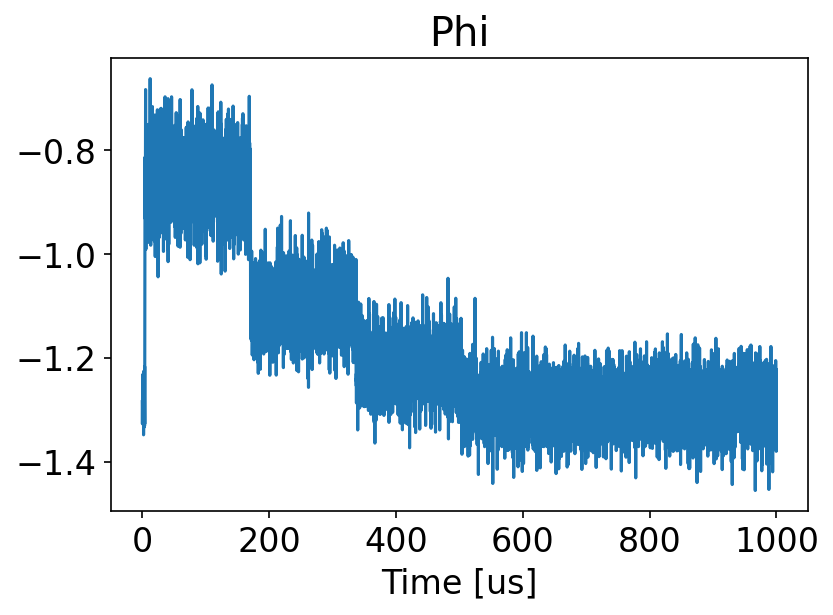

In [69]:
class PhaseFastProgram(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1, mixer_freq=0)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(0.7*self.cfg['period'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],                             
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="periodic")
        
        # Write conditional register.
        self.regwi(0,2,self.cfg['cond_jump'],"Conditional Jump")
        
        # Send pulse out.
        self.pulse(ch=self.cfg["gen_ch"])
        
        # Sync.
        self.synci(self.us2cycles(self.cfg['wait_start']))
    
    def body(self):
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'!=',15,'JUMP')
        self.trigger(pins=[4,5,6,7,8,9,10,11]) # play readout pulse
        self.label('JUMP')
        
        self.trigger(adcs=self.ro_chs, pins=[0])                
        self.synci(self.us2cycles(self.cfg['period']))
        
config={"gen_ch"      : 2,
        "ro_ch"       : 6,
        "reps"        : 10000,
        "pulse_length": 10,
        "pulse_gain"  : 30000, # [DAC units]
        "pulse_freq"  : 498, # [MHz]
        "cond_jump"   : 10,
        "period"      : 0.1,
        "wait_start"  : 20
       }

prog = PhaseFastProgram(soccfg, config)
prog.acquire(soc, progress=False)

# Plot data.
nsamp = prog.ro_chs[config['ro_ch']]['length'] # samples for each capture
di = prog.di_buf[0]/nsamp # Averaging
dq = prog.dq_buf[0]/nsamp # Averaging
diq = di + 1j*dq
a = np.abs(diq)
phi = np.angle(diq)
n = config['period']*np.arange(len(di)) # Sampling period

# Plot results.
# plt.figure(dpi=150)
# plt.plot(n,di)
# plt.title("Real Part")

# plt.figure(dpi=150)
# plt.plot(n,dq)
# plt.title("Imaginary Part")

plt.figure(dpi=150)
plt.plot(n,np.unwrap(phi))
plt.xlabel("Time [us]");
plt.title("Phi");

In this example, `cfg['nstep'] = 3` and `cfg['sweep_time'] = 500` so the resonator took 3 steps to jump from one frequency to the other in a total of 500 us.

Try it with different choices of `cfg['nstep']` and `cfg['sweep_time']`.

# We read a superconducting qubit out using the readout resonator that it is coupled to.

When a qubit decays from its excited state to its ground state, its readout resonator jumps back from “e”to “g” instantaneously at random times given by a Poisson distribution with a time scale set by the qubit’s T1 time. In the next lab, we will specify the amount of T1 decay we want by specifying the probability for the resonator to jump: `prob_t1`.

What would it look like for a qubit to undergo T1 decay after 400 us? Make the appropriate resonator configuration and re-do the Phi vs. time plot with that new configuration.

In [70]:
## Solution:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : 499.3}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = 400 # 100, decay time
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 499.3 MHz, fd = -115.09999999999997 MHz, k = 232, fdds = 0.10000000000002274 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.10000000000002274
AxisKidsimV3: dds_wait   = 3839
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 400
AxisKidsimV3: nstep      = 1
freq = 683, bval = 6144, slope = 6144, steps = 1, wait = 3839
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


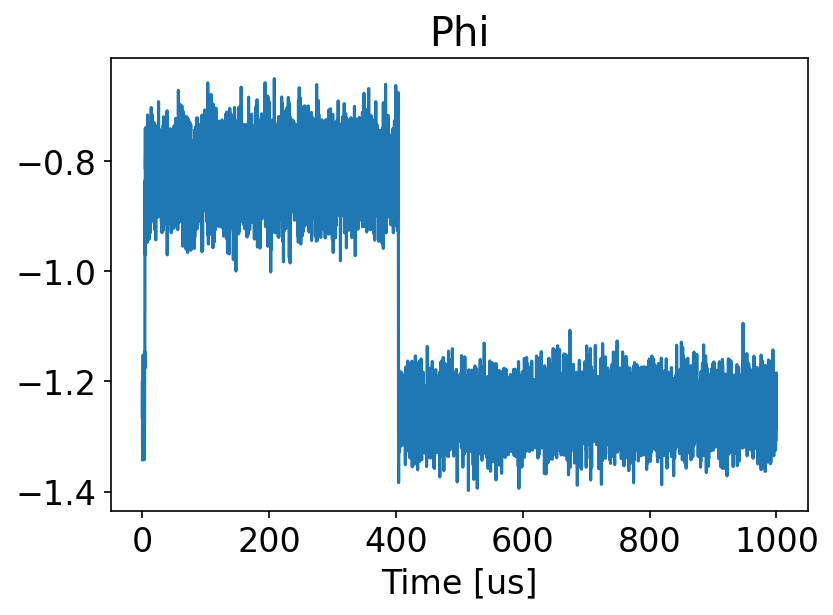

In [71]:
prog = PhaseFastProgram(soccfg, config)
prog.acquire(soc, progress=False)

# Plot data.
nsamp = prog.ro_chs[config['ro_ch']]['length'] # samples for each capture
di = prog.di_buf[0]/nsamp # Averaging
dq = prog.dq_buf[0]/nsamp # Averaging
diq = di + 1j*dq
a = np.abs(diq)
phi = np.angle(diq)
n = config['period']*np.arange(len(di)) # Sampling period

# Plot results.
# plt.figure(dpi=150)
# plt.plot(n,di)
# plt.title("Real Part")

# plt.figure(dpi=150)
# plt.plot(n,dq)
# plt.title("Imaginary Part")

plt.figure(dpi=150)
plt.plot(n,np.unwrap(phi))
plt.xlabel("Time [us]");
plt.title("Phi");